In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import load, dump
import tempfile
import shutil
import os

In [2]:
class KBandit:
    def __init__(self, K, epsilon, step_size, method, label, non_stationary=False, optimistic_initial=0, ucb_param=0):
        self.K = K
        self.epsilon = epsilon
        self.step_size = step_size
        self.choices = np.arange(self.K)
        self.method = method
        self.label = label
        self.non_stationary = non_stationary
        self.optimistic_initial = optimistic_initial
        self.ucb_param = ucb_param

    def initialize(self):
        if self.non_stationary:
            self.Q_True = np.zeros(self.K)
        else:
            self.Q_True = np.random.randn(self.K)

        self.Q_Estimated = np.zeros(self.K) + self.optimistic_initial
        self.num_steps = 0
        self.action_freq = np.zeros(self.K)
        self.best_action = np.argmax(self.Q_True)
    
    def get_action(self):
        prob = np.random.rand()
        if prob < self.epsilon:
            return np.random.choice(self.choices)
        elif self.ucb_param != 0:
            UCB_Q_Estimated = self.Q_Estimated + (self.ucb_param * np.sqrt((np.log(self.num_steps+1))/(self.action_freq + 1e-5)))
            return np.argmax(UCB_Q_Estimated)
        else:
            return np.argmax(self.Q_Estimated)

    def take_action(self, action_choice):
        reward = np.random.randn() + self.Q_True[action_choice]
        self.num_steps += 1
        self.action_freq[action_choice] += 1

        if self.method=='sample_averages':
            self.Q_Estimated[action_choice] += ((reward - self.Q_Estimated[action_choice]) / self.action_freq[action_choice])

        elif self.method == 'constant_step_size':
            self.Q_Estimated[action_choice] += (self.step_size * (reward - self.Q_Estimated[action_choice]))

        else:
            raise ValueError('method should be either of the two: [sample_averages, constant_step_size]')

        return reward

In [3]:
class Simulation:
    def __init__(self, num_runs, num_steps):
        self.num_runs = num_runs
        self.num_steps = num_steps

    def kernel(self, bandit):
        all_rewards = np.zeros(self.num_steps)
        best_action_freq = np.zeros(self.num_steps)
        bandit.initialize()
        for t in range(self.num_steps):
            if bandit.non_stationary:
                bandit.Q_True += np.random.normal(0, 0.01, bandit.K)
                bandit.best_action = np.argmax(bandit.Q_True)
            action = bandit.get_action()
            reward = bandit.take_action(action)
            all_rewards[t] = reward
            if action == bandit.best_action:
                best_action_freq[t] = 1
        
        return best_action_freq, all_rewards

    def simulate(self, bandit):
        folder = tempfile.mkdtemp()
        data_folder = os.path.join(folder, 'data')
        dump(bandit, data_folder)
        bandit = load(data_folder, mmap_mode='r')

        results = Parallel(n_jobs=-1)(delayed(self.kernel)(bandit) for i in range(self.num_runs))

        best_action_freq, all_rewards = zip(*results)

        best_action_freq = np.array(best_action_freq)
        all_rewards = np.array(all_rewards)

        try:
            shutil.rmtree(folder)
        except:
            print("Failed to delete: " + folder)

        mean_best_action_counts = best_action_freq.mean(axis=0)
        mean_rewards = all_rewards.mean(axis=0)
        return mean_best_action_counts, mean_rewards

In [4]:
class Experiment:
    def __init__(self, bandits, num_runs, num_steps):
        self.bandits = bandits
        self.num_runs = num_runs
        self.num_steps = num_steps
        self.rewards_for_bandits = np.zeros((len(bandits), num_steps))
        self.actions_for_bandits = np.zeros((len(bandits), num_steps))

    def run_experiment(self):
        for i, each_bandit in enumerate(self.bandits):
            simulation = Simulation(self.num_runs, self.num_steps)
            mean_best_action_freq_per_step, mean_rewards_per_step = simulation.simulate(each_bandit)
            self.rewards_for_bandits[i, :] = mean_rewards_per_step
            self.actions_for_bandits[i, :] = mean_best_action_freq_per_step

    def plot_mean_rewards_per_step(self, filename):
        plt.figure(figsize=(20, 10))
        for i in range(len(self.bandits)):
            mean_rewards_per_step = self.rewards_for_bandits[i]
            plt.plot(np.arange(1, len(mean_rewards_per_step)+1), mean_rewards_per_step, label=self.bandits[i].label)
            plt.xlabel('steps')
            plt.ylabel('average reward')
            plt.legend()
        plt.savefig('{0}.png'.format(filename))
        plt.show()

    def plot_mean_best_action_freq_per_step(self, filename):
        plt.figure(figsize=(20, 10))
        for i in range(len(self.bandits)):
            mean_best_action_freq_per_step = self.actions_for_bandits[i]
            plt.plot(np.arange(1, len(mean_best_action_freq_per_step)+1), mean_best_action_freq_per_step, label=self.bandits[i].label)
            plt.xlabel('steps')
            plt.ylabel('%\ optimal action')
            plt.legend()
        plt.savefig('{0}.png'.format(filename))
        plt.show()

### Q1

In [5]:
def Q1():
    bandit_1 = KBandit(K = 10, epsilon = 0.1, step_size = 0.1, method = 'constant_step_size', label='Constant Step Size', non_stationary=True, optimistic_initial=0, ucb_param=0)
    bandit_2 = KBandit(K = 10, epsilon = 0.1, step_size = 0, method = 'sample_averages', label='Sample Averages', non_stationary=True, optimistic_initial=0, ucb_param=0)
    bandits = [bandit_1, bandit_2]
    exp = Experiment(bandits, 2000, 10000)
    exp.run_experiment()
    exp.plot_mean_rewards_per_step('Q1-average-rewards')
    exp.plot_mean_best_action_freq_per_step('Q1-optimal-action')

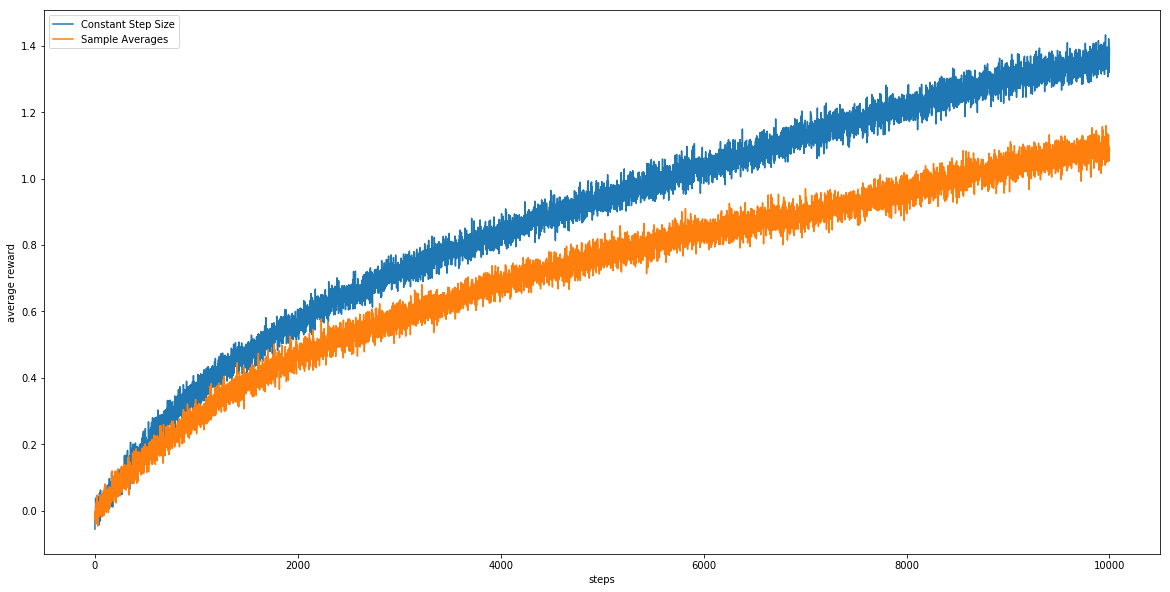

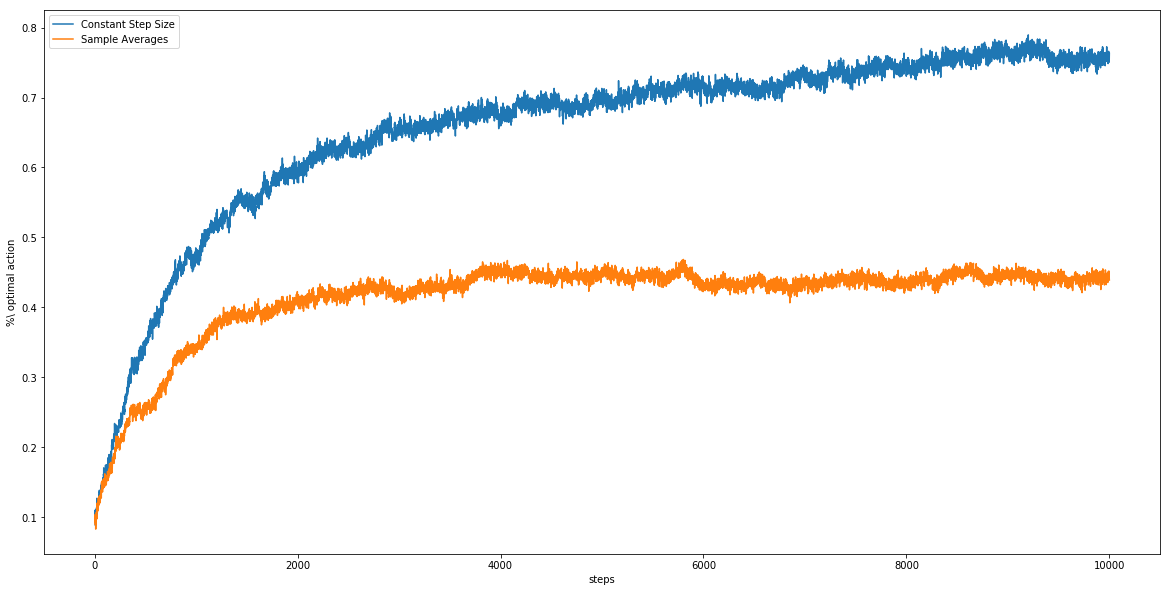

In [6]:
Q1()

### Q2

In [7]:
def Q2(non_stationary):
    bandit_1 = KBandit(K = 10, epsilon = 0, step_size = 0.1, method = 'constant_step_size', label='Optimistic', non_stationary=non_stationary, optimistic_initial=5, ucb_param=0)
    bandit_2 = KBandit(K = 10, epsilon = 0.1, step_size = 0.1, method = 'constant_step_size', label='Epsilon Greedy', non_stationary=non_stationary, optimistic_initial=0, ucb_param=0)
    bandits = [bandit_1, bandit_2]
    exp = Experiment(bandits, 2000, 1000)
    exp.run_experiment()
    if non_stationary:
        exp.plot_mean_rewards_per_step('Q2-average-rewards-non-stationary')
        exp.plot_mean_best_action_freq_per_step('Q2-optimal-action-non-stationary')
    else:
        exp.plot_mean_rewards_per_step('Q2-average-rewards-stationary')
        exp.plot_mean_best_action_freq_per_step('Q2-optimal-action-stationary')

#### Stationary

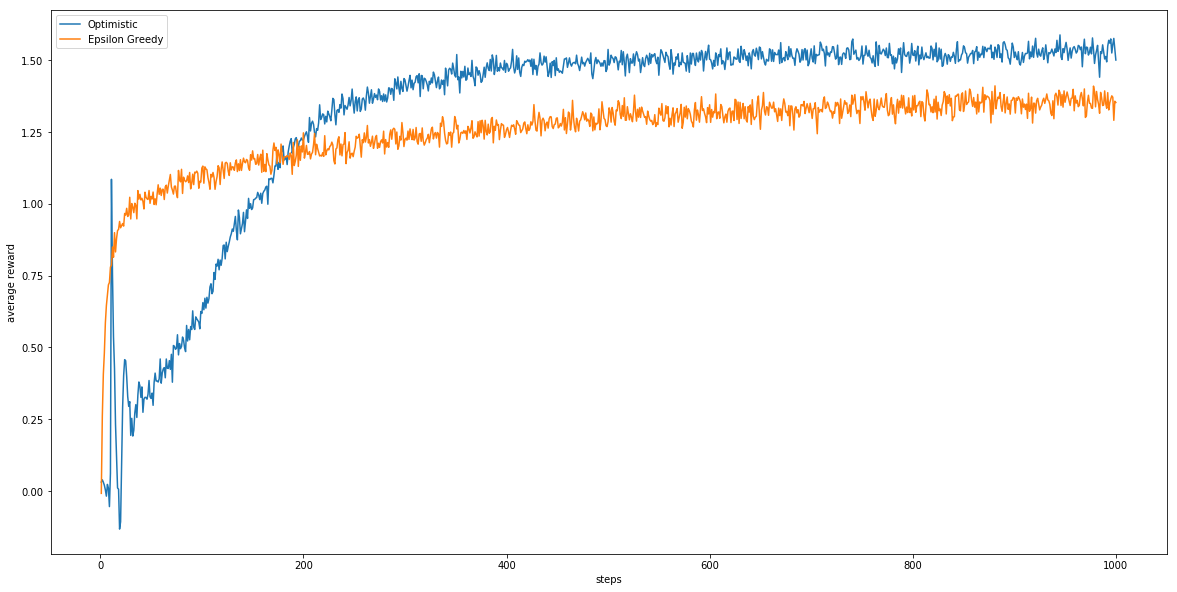

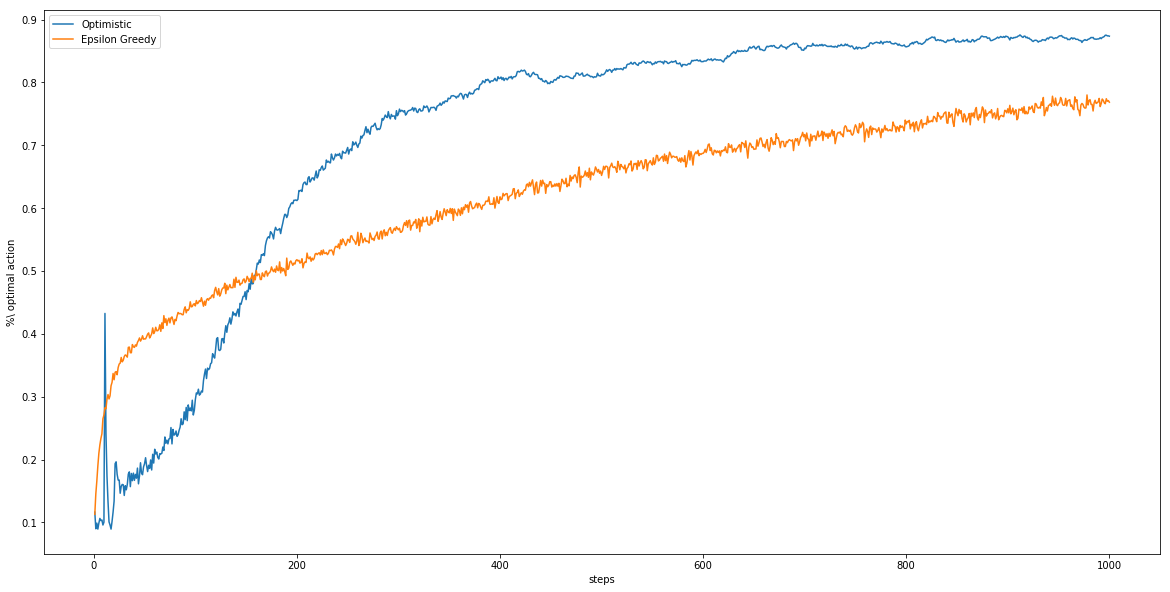

In [8]:
Q2(non_stationary=False)

#### Non Stationary

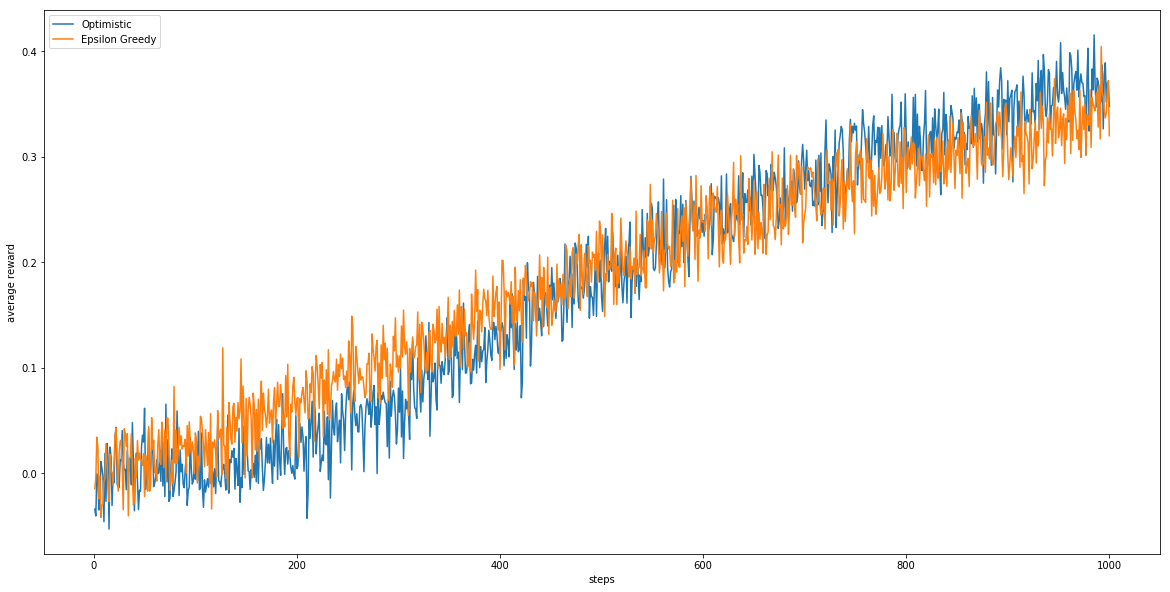

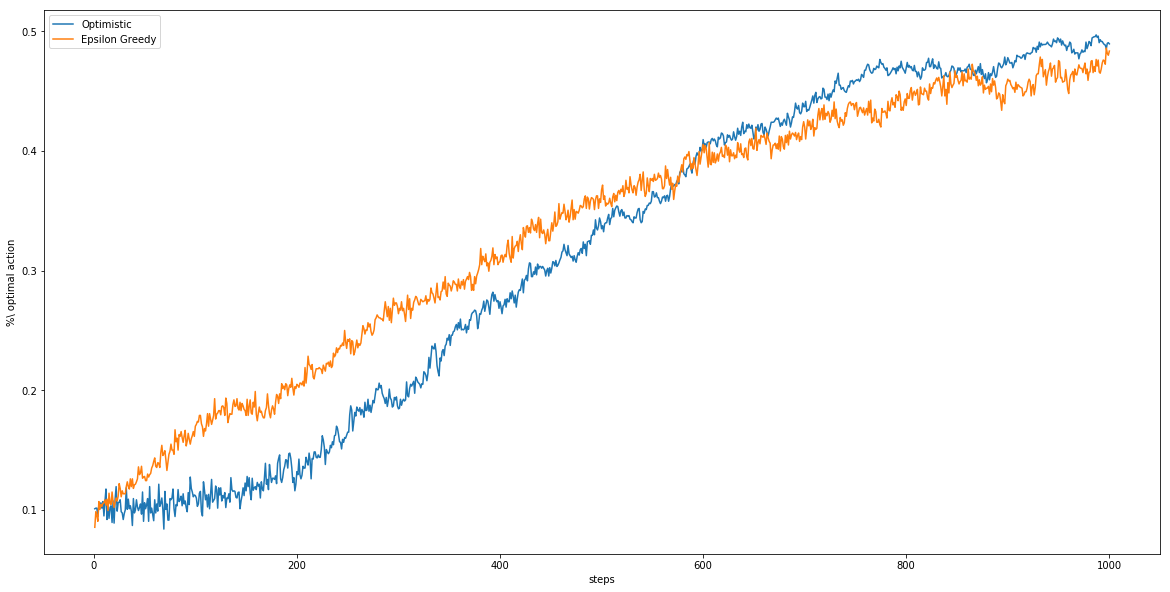

In [9]:
Q2(non_stationary=True)

### Q4

In [10]:
def Q4(non_stationary):
    bandit_1 = KBandit(K = 10, epsilon = 0, step_size = 0.1, method = 'constant_step_size', label='Optimistic', non_stationary=non_stationary, optimistic_initial=5, ucb_param=0)
    bandit_2 = KBandit(K = 10, epsilon = 0.1, step_size = 0.1, method = 'constant_step_size', label='Epsilon Greedy', non_stationary=non_stationary, optimistic_initial=0, ucb_param=0)
    bandit_3 = KBandit(K = 10, epsilon = 0, step_size = 0.1, method = 'constant_step_size', label='UCB', non_stationary=non_stationary, optimistic_initial=0, ucb_param=2)
    bandits = [bandit_1, bandit_2, bandit_3]
    exp = Experiment(bandits, 2000, 10000)
    exp.run_experiment()
    if non_stationary:
        exp.plot_mean_rewards_per_step('Q4-average-rewards-non-stationary')
        exp.plot_mean_best_action_freq_per_step('Q4-optimal-action-non-stationary')
    else:
        exp.plot_mean_rewards_per_step('Q4-average-rewards-stationary')
        exp.plot_mean_best_action_freq_per_step('Q4-optimal-action-stationary')

#### Stationary

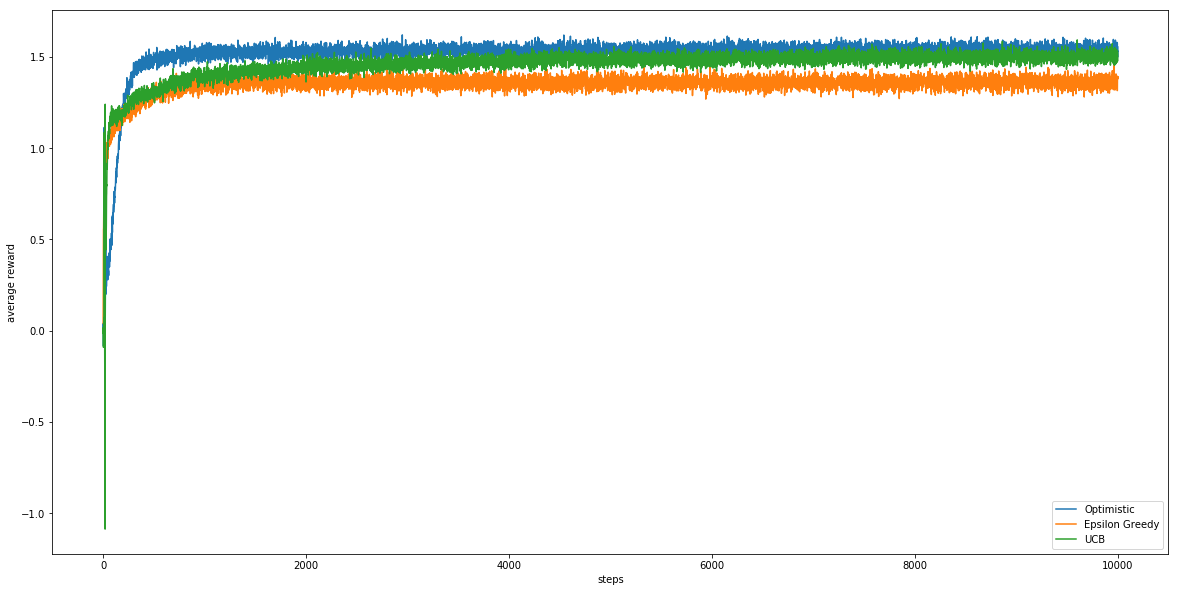

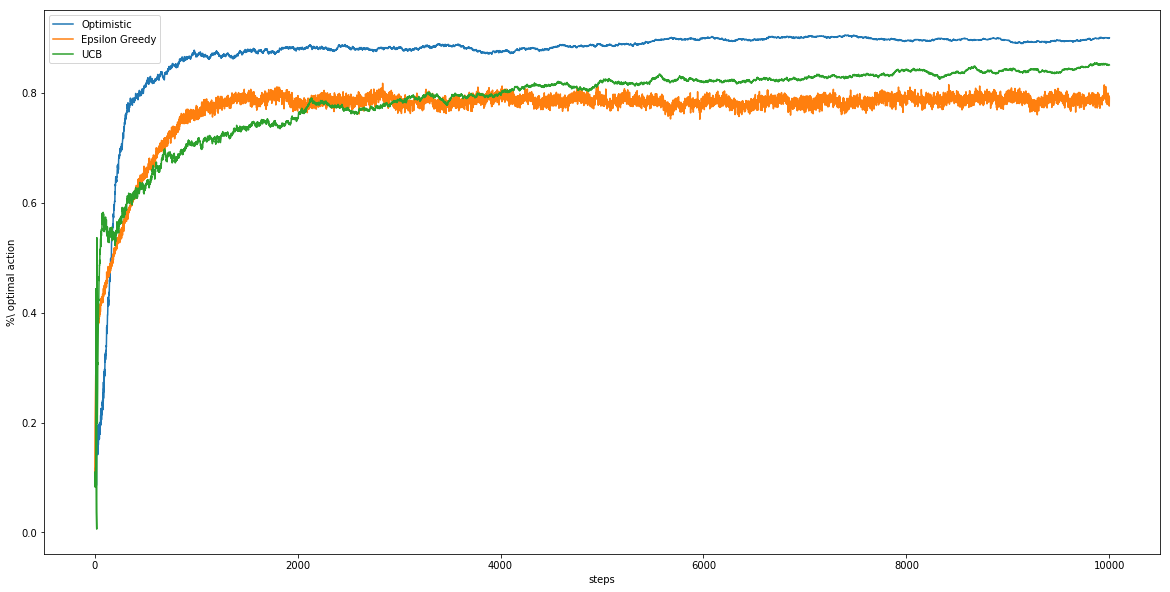

In [11]:
Q4(non_stationary=False)

#### Non Stationary

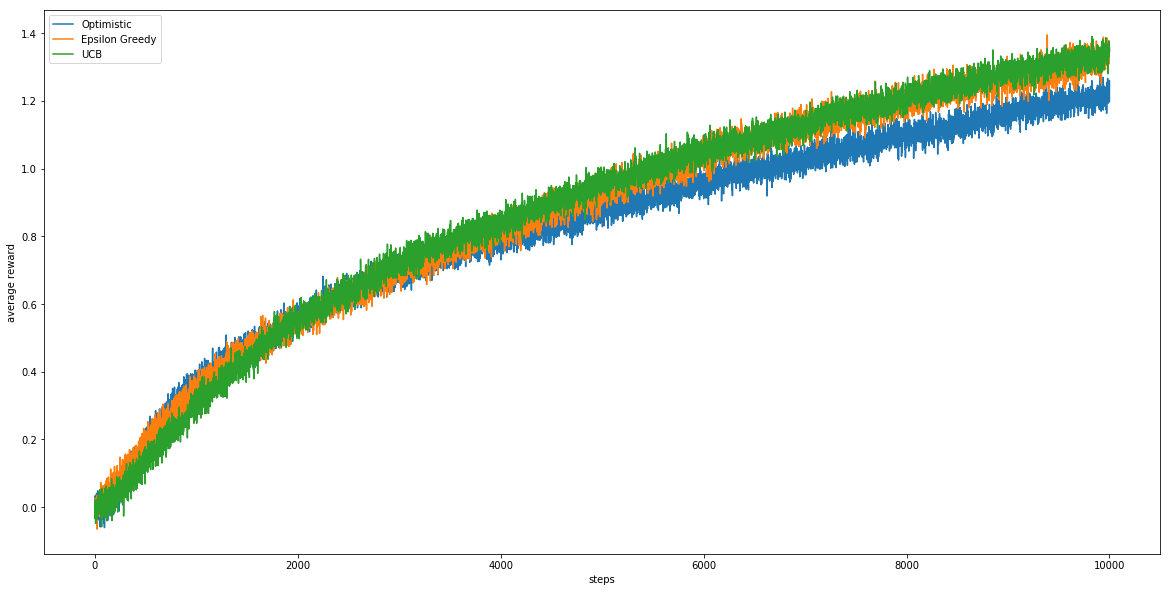

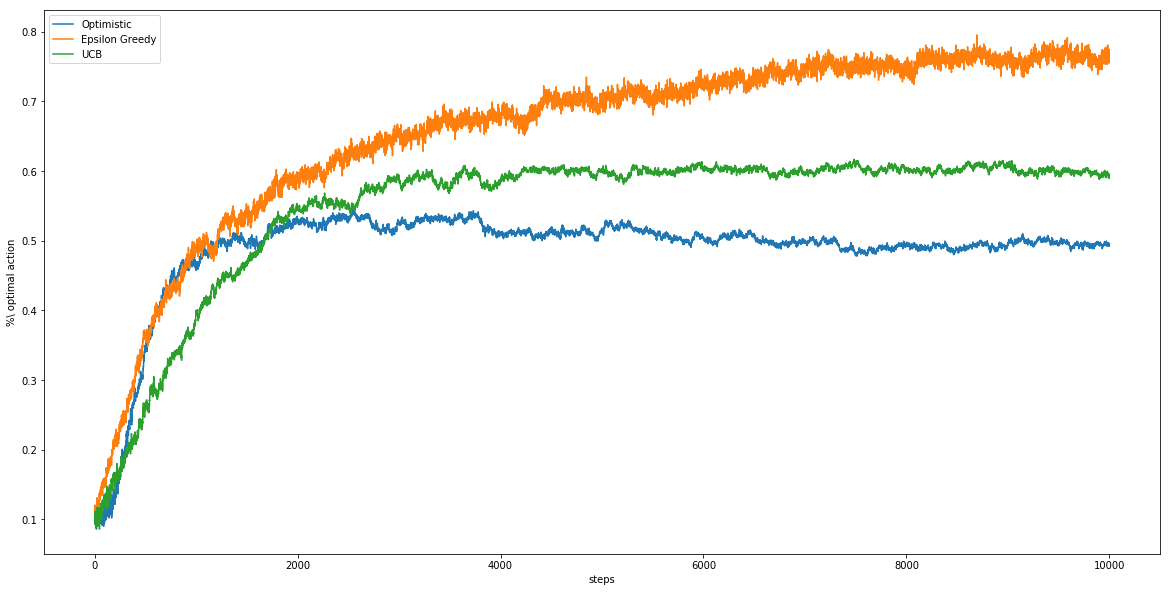

In [12]:
Q4(non_stationary=True)